In [ ]:
import utils
import numpy as np
import matplotlib.pyplot as plt

MAX_SPEED_FLEXPICKER = 10
MAX_ACCELERATION_FLEXPICKER = 100
TIME_STEP = 1/240

# On veut une vitesse de 1 * 10 = 10 m/s
vel_scaling_factor = 0.4
acc_scaling_factor = 1

init_pos = (0,0,0)
init_orn = (0,0,0,0)
target_pos = (0.1, 0.1, 0.17)
target_orn = (0,0,0,0)
print("distance", np.linalg.norm(np.array(init_pos)-np.array(target_pos)))
pos, orn, v = utils.ctraj_pilz_KDL(init_pos, init_orn, target_pos, target_orn, MAX_SPEED_FLEXPICKER, MAX_ACCELERATION_FLEXPICKER, vel_scaling_factor, acc_scaling_factor, 2*np.pi, TIME_STEP)

plt.plot(np.arange(0, len(v))/240, np.sqrt(v[:, 0]**2+v[:, 1]**2+v[:, 2]**2))
plt.show()
#plot the derivative of the speed
plt.plot(np.arange(0, len(v)-1)/240, np.sqrt((np.diff(v[:, 0])*240)**2+(np.diff(v[:, 1])*240)**2+(np.diff(v[:, 2])*240)**2))
plt.show()
# On atteind seulement 4.5 m/s alors que le robot devrait atteindre les 3 m/s également si la distance était trop petite pour atteindre la vitesse vouloue non ?

In [ ]:
from utils import PickAndPlaceReward
import torch
from environment import TossingFlexpicker

env = TossingFlexpicker(GUI=False)
pickAndPlaceReward = PickAndPlaceReward()
pickAndPlaceReward.load_state_dict(torch.load("models/PaP_reward.pt"))
pickAndPlaceReward.evaluation(env, 10000)

In [ ]:
from environment import TossingFlexpicker

#check gymnasium environment
env = TossingFlexpicker(GUI=False)


In [ ]:
!python3 train_agent.py --agent sac --reward neural_net --save_path models/SAC_SBX --episodes 10000

171.0argv[0]=

Version = 4.1 Metal - 83
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
gripper open in 0.16666666666666677 seconds


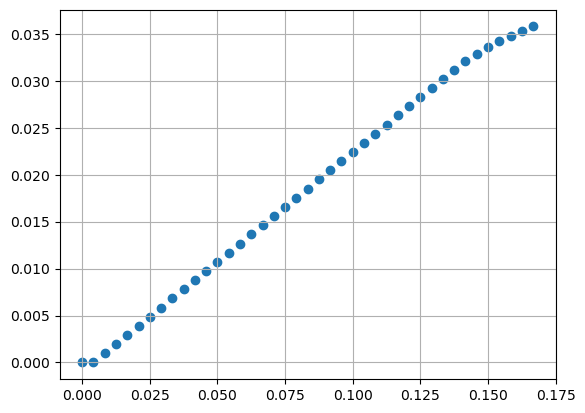

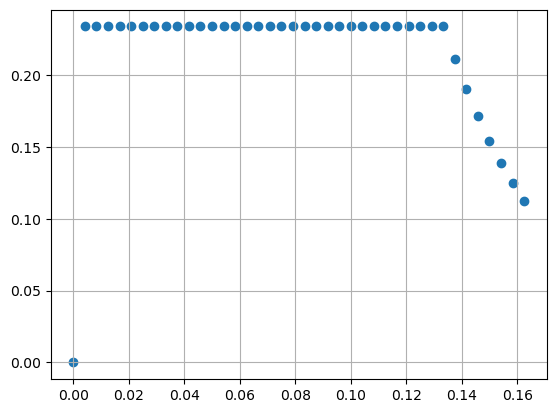

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


: 

In [2]:
import environment as env
import numpy as np
import flexpicker as fp
import pybullet as p
import time
import pybullet_data
from pybullet_utils import bullet_client as bc
import matplotlib.pyplot as plt
physicsClient = bc.BulletClient(connection_mode=True, options="")
physicsClient.configureDebugVisualizer(physicsClient.COV_ENABLE_GUI, 0)
physicsClient.configureDebugVisualizer(physicsClient.COV_ENABLE_PLANAR_REFLECTION, 0)
physicsClient.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
physicsClient.setGravity(0,0,-10)
planeId = physicsClient.loadURDF("plane.urdf")
startPos = [0,0,1]
startOrientation = physicsClient.getQuaternionFromEuler([0,np.pi,0])
shift = 0.0112778
delay_gripper = 0.171
flexpicker = fp.Flexpicker(delay_gripper, startPos, startOrientation, True, physicsClient)
#set the center of mass frame (loadURDF sets base link frame) startPos/Ornp.resetBasePositionAndOrientation(boxId, startPos, startOrientation)
flexpicker.open_gripper()
time_elapsed = 0
done = False
open_length_list = []
open_length_list.append(physicsClient.getLinkState(flexpicker.id, 7)[0][1] - shift)
openning_speed_list = []
while flexpicker.is_gripper_open() == False:
    physicsClient.stepSimulation()
    open_length_list.append((physicsClient.getLinkState(flexpicker.id, 7)[0][1] - shift))
    time.sleep(1./240.)
    openning_speed_list.append((open_length_list[-1] - open_length_list[-2])/(1./240.))
    time_elapsed += 1./240.
print(f"gripper open in {time_elapsed} seconds")
#plot the open length
plt.scatter(np.arange(0, len(open_length_list))/240, open_length_list)
#add grid
plt.grid()
plt.show()

plt.scatter(np.arange(0, len(openning_speed_list))/240, openning_speed_list)
plt.grid()
plt.show()

physicsClient.disconnect()
